In [4]:
import pandas as pd
import numpy as np


df = pd.read_csv(r"c:\Users\asus\OneDrive\Desktop\HPP\house_pricing_df.csv")


print(df.isna().sum())

Net_Metrekare             0
Brüt_Metrekare            0
Oda_Sayısı              260
Bulunduğu_Kat          2297
Eşya_Durumu            7398
Binanın_Yaşı              0
Isıtma_Tipi               0
Fiyat                     0
Şehir                     0
Binanın_Kat_Sayısı        0
Kullanım_Durumu           0
Yatırıma_Uygunluk      5576
Takas                  5895
Tapu_Durumu           10566
Banyo_Sayısı             46
dtype: int64


# Data Cleaning

## Outliers and Duplicated Rows Handling 

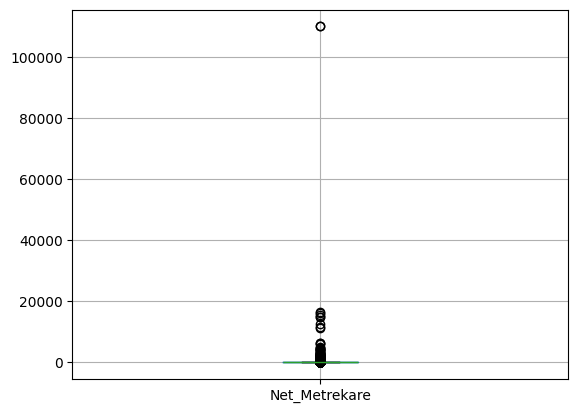

The number of outliers in Net_Metrekare : 988


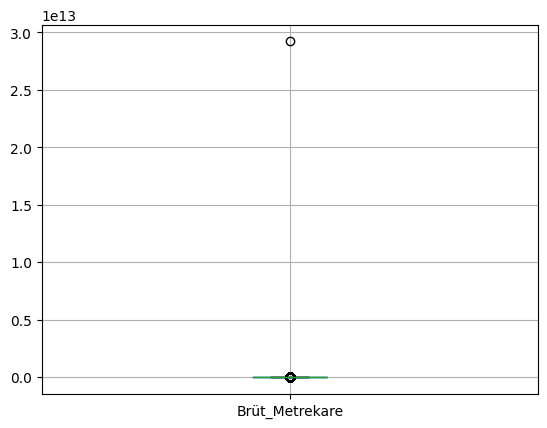

The number of outliers in Brüt_Metrekare : 1278


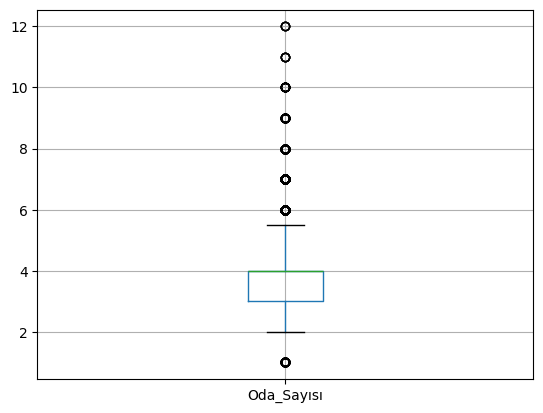

The number of outliers in Oda_Sayısı : 1073


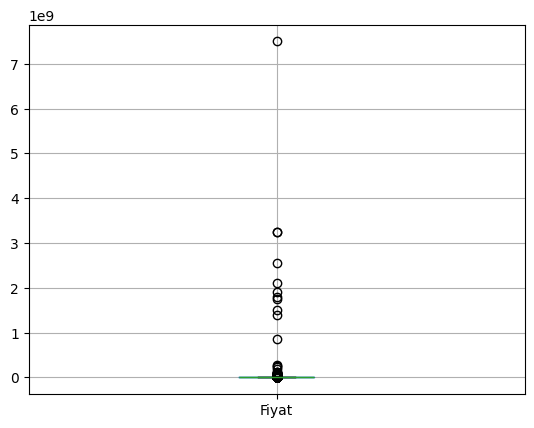

The number of outliers in Fiyat : 1824


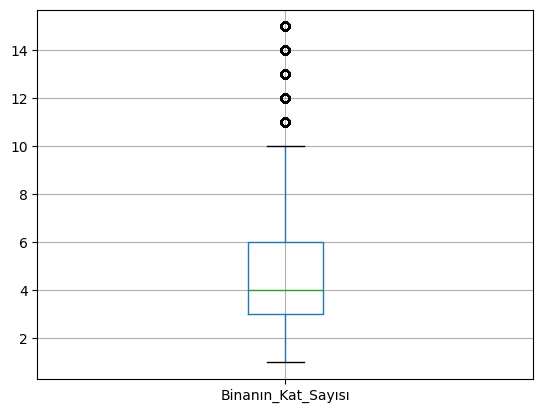

The number of outliers in Binanın_Kat_Sayısı : 1793


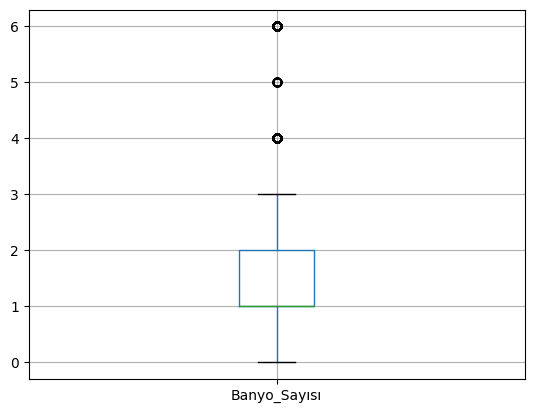

The number of outliers in Banyo_Sayısı : 463


In [5]:
import matplotlib.pyplot as plt

numerical_columns = ["Net_Metrekare", "Brüt_Metrekare", "Oda_Sayısı", "Fiyat", "Binanın_Kat_Sayısı", "Banyo_Sayısı"]
categorial_columns = ["Bulunduğu_Kat","Eşya_Durumu","Binanın_Yaşı","Isıtma_Tipi","Şehir","Kullanım_Durumu","Yatırıma_Uygunluk","Takas"]

# Here I deleted any duplicated rows    
df.drop_duplicates(keep='first', inplace=True)

# Here I created a boxplot to visualize the outliers.
for col in numerical_columns:
    
   
    counter = 0

    df.boxplot(column = col)
    plt.show()
    q1,q3 = df[col].quantile([0.25,0.75])
    iqr = q3 - q1
    limit_1 = q1-1.5*iqr
    limit_2 = q3+1.5*iqr

    for value in df[col]:
        if value < limit_1 or value > limit_2:
            counter += 1
    print(f"The number of outliers in {col} : {counter}")
# Here I dropped the data that is above 95% and below 5% of the data 
    df[col] = df[col].clip(upper = df[col].quantile(0.98))
    df[col] = df[col].clip(lower = df[col].quantile(0.02))
         



## Imputation

In [6]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# I deleted the Tapu Durumu column here because it is half empty
df = df.drop("Tapu_Durumu" , axis = 1)

# I used KNN imputer to fill the Nan values by comparing neighbour features
imputer_scaler1 = MinMaxScaler()
imputer_scaler2 = MinMaxScaler()
imputer_encoder = OrdinalEncoder(encoded_missing_value=np.nan)

imputer_encoded_data = imputer_encoder.fit_transform(df[categorial_columns])

imputer_scaled_num = imputer_scaler1.fit_transform(df[numerical_columns])
imputer_scaled_cat = imputer_scaler2.fit_transform(imputer_encoded_data)

full_data_scaled = np.hstack([imputer_scaled_num, imputer_scaled_cat])


imputer = KNNImputer(n_neighbors=7, weights='distance')
full_data_imputed_array = imputer.fit_transform(full_data_scaled)

all_column_names = numerical_columns + categorial_columns
df_imputed = pd.DataFrame(full_data_imputed_array, columns=all_column_names)


df[numerical_columns] = imputer_scaler1.inverse_transform(df_imputed[numerical_columns]).round()
df[categorial_columns] = imputer_scaler2.inverse_transform(df_imputed[categorial_columns]).round()

df[categorial_columns] = imputer_encoder.inverse_transform(df[categorial_columns])


print(df)



       Net_Metrekare  Brüt_Metrekare  Oda_Sayısı      Bulunduğu_Kat  \
0              120.0           150.0         4.0              4.Kat   
1              100.0           125.0         4.0              3.Kat   
2               89.0            95.0         3.0              4.Kat   
3               45.0            55.0         2.0              6.Kat   
4              140.0           150.0         4.0  Düz Giriş (Zemin)   
...              ...             ...         ...                ...   
20321          130.0           140.0         4.0              4.Kat   
20322           95.0           115.0         3.0              2.Kat   
20323          125.0           155.0         4.0              1.Kat   
20324           50.0            70.0         2.0       Yüksek Giriş   
20325          110.0           130.0         3.0              2.Kat   

      Eşya_Durumu Binanın_Yaşı     Isıtma_Tipi      Fiyat  Şehir  \
0          Eşyalı  21 Ve Üzeri  Kombi Doğalgaz   950000.0  adana   
1          